### Imports and initialization

In [1]:
from torch.utils.data import DataLoader
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset
from torch.utils.data.sampler import SubsetRandomSampler

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix,f1_score, accuracy_score
import numpy as np
import pandas as pd
import pickle

from tqdm import tqdm

import matplotlib.pyplot as plt

In [2]:
import sys
import os
sys.path.append('../')

from src import Dataset
from src.network import MLP

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] ="7" #specify gpu to use

### Load dataset

In [4]:
data_root = '../data/'
dataset = Dataset(data_root, data_source='neuropixels', labels_col='brain_region') #specify data location

Found processed pickle. Loading from '../data/processed/neuropixels_dataset-labels_brain_region.pkl'.


In [5]:
dataset.cell_type_labels

['grey', 'cortex', 'midbrain', 'hippocampus', 'thalamus', 'other']

In [6]:
# cell classes identified by Louis as not being too quiet
keepers = ['grey', 'cortex', 'midbrain', 'hippocampus', 'thalamus']
dataset.drop_other_classes(classes_to_keep=keepers)

### Split dataset

In [7]:
random_seed = 1
test_size, val_size = 0.2, 0.2

dataset.split_cell_train_val_test(test_size=test_size, val_size=val_size, seed=random_seed)
X_train, y_train = dataset.get_set('train')
X_val, y_val = dataset.get_set('val')
X_test, y_test = dataset.get_set('test')

In [8]:
np.unique(y_test, return_counts=True)

(array([0., 1., 2., 3., 4.]), array([18100, 43600,  5200, 18100, 18100]))

### Compute ISI distribution

In [9]:
def compute_hist(X, bins, a_min=-2.5, a_max=0.5):
    X_isi = np.zeros((X.shape[0], bins))
    bins = np.linspace(a_min, a_max, bins+1)
    for i, x in enumerate(X):
        # compute isi
        x = np.diff(x)
        # compute histogram
        x = np.log10(x)
        # x = np.clip(x, a_min=a_min, a_max=a_max)
        X_isi[i] = np.histogram(x, bins)[0].astype(int)
    return X_isi

In [10]:
num_bins = 128

In [11]:
X_train = compute_hist(X_train, bins=num_bins)
X_val = compute_hist(X_val, bins=num_bins)
X_test = compute_hist(X_test, bins=num_bins)

In [12]:
# reshape to (num_cells, num_trials, num_isi_bins)
X_train = X_train.reshape(100, -1, num_bins).transpose(1,0,2)
X_val = X_val.reshape(100, -1, num_bins).transpose(1,0,2)
X_test = X_test.reshape(100, -1, num_bins).transpose(1,0,2)

print(X_train.shape)

(3093, 100, 128)


In [13]:
y_train = y_train.reshape(100, -1).T[:, 0]
y_val = y_val.reshape(100, -1).T[:, 0]
y_test = y_test.reshape(100, -1).T[:, 0]

### Torch Dataset

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train, y_train = torch.FloatTensor(X_train).to(device), torch.LongTensor(y_train).to(device)
train_dataset = TensorDataset(X_train, y_train)

X_test, y_test = torch.FloatTensor(X_test).to(device), torch.LongTensor(y_test).to(device)
test_dataset = TensorDataset(X_test, y_test)

X_val, y_val = torch.FloatTensor(X_val).to(device), torch.LongTensor(y_val).to(device)
val_dataset = TensorDataset(X_val, y_val)

### Weighted sampler

In [15]:
_, class_sample_count = torch.unique(y_train, return_counts=True)
increase_factor = torch.floor(torch.pow(1.5, torch.floor(9 - torch.log(class_sample_count))))
indices = []
for cell_type, factor in enumerate(increase_factor.cpu()):
    cell_indices = torch.where(y_train==cell_type)[0]
    for _ in range(int(factor)):
        indices.append(cell_indices)
        
print(increase_factor)

indices = torch.cat(indices)
sampler = SubsetRandomSampler(indices)

tensor([2., 1., 3., 2., 2.], device='cuda:0')


In [16]:
train_loader = DataLoader(train_dataset, batch_size=128, sampler=sampler, drop_last=True)
train_eval_loader = DataLoader(train_dataset, batch_size=512, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)

### Model

In [17]:
import torch.nn as nn

import torch.nn as nn


class EncoderAggr(nn.Module):
    def __init__(self, encoder, classifier, dropout_p=0.):
        super().__init__()
        self.encoder = encoder
        self.classifier = classifier
        
        self.dropout_p = dropout_p
        
    def dropout(self, x):
        if self.training and not self.dropout_p == 0:
            dropout_mask = torch.empty((x.size(0), x.size(1), 1), dtype=torch.float32, device=x.device).uniform_(0, 1) > self.dropout_p
            dropout_ratio = dropout_mask.sum(dim=1) / dropout_mask.size(1)

            x = x * dropout_mask / dropout_ratio.view(x.size(0), 1, -1)
        return x
        
    def forward(self, x):
        batch_size = x.size(0)
        x = x.view(-1, num_bins)
        emb = self.encoder(x)
        
        # aggregate feats
        emb = emb.view(batch_size, 100, -1)
        
        # feature dropout
        emb = self.dropout(emb)
        
        # compute global embedding
        global_emb = torch.mean(emb, dim=1)
        
        out = self.classifier(global_emb)
        
        return nn.functional.log_softmax(out, dim=1)

class MLPAggr(nn.Module):
    def __init__(self, feat_dropout_p=0.2, net_dropout_p=0.2):
        super().__init__()
        encoder = nn.Sequential(nn.Linear(128, 64), nn.ReLU(), nn.Dropout(net_dropout_p), 
                                nn.Linear(64, 32), nn.ReLU(), nn.Dropout(net_dropout_p), 
                                nn.Linear(32, 32))
        classifier = nn.Sequential(nn.Linear(32, 12), nn.ReLU(), nn.Linear(12, 6))
        self.model = EncoderAggr(encoder, classifier, feat_dropout_p)

    def forward(self, x):
        out = self.model(x)
        return out

In [18]:
class topk_NLLLoss(nn.Module):
    def __init__(self, top_k=0.7):
        super().__init__()
        self.loss = nn.NLLLoss(reduction='none')
        self.top_k = top_k
    
    def forward(self, input, target):
        loss = self.loss(input, target)

        if self.top_k == 1:
            return torch.mean(loss)
        else:
            valid_loss, idxs = torch.topk(loss, int(self.top_k * loss.size()[0]))    
            return torch.mean(valid_loss)

In [19]:
#RUN THE MODEL
model = MLPAggr(feat_dropout_p=0.7, net_dropout_p=0.2).to(device)

lr = 1e-3
weight_decay = 1e-5
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
criterion = topk_NLLLoss(0.8)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5000], gamma=0.1)

In [20]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model)

11866

### Run the model

In [21]:
def train(model, device, train_loader, optimizer):
    model.train()
    avg_loss = 0.
    step = 0
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        avg_loss += loss.item()
        step += 1
        
    print('loss %.3f (%d)' %(avg_loss/step, step))


def test(model, device, loader):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    preds = []
    corrects = []
    with torch.no_grad():
        for data, target in loader:
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            pred_ = np.ndarray.flatten(pred.cpu().numpy())
            targ_ = target.cpu().numpy()
            preds.append(pred_)
            corrects.append(targ_)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += len(target)
    corrects = np.hstack(corrects)
    preds = np.hstack(preds)
    
    acc = accuracy_score(corrects, preds)
    f1score = f1_score(corrects, preds, average='macro')
    cm = confusion_matrix(corrects, preds, normalize='true')
    return acc, f1score

### Run Hyperparameter Grid

In [22]:
epochs = 1000

for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer)
    train_cm, train_acc = test(model, device, train_loader)
    val_cm, val_acc = test(model, device, val_loader)
    test_cm, test_acc = test(model, device, test_loader)
    
    print('Train: %.2f, Val: %.2f, Test: %.2f' %(train_acc, val_acc, test_acc))

loss 1.818 (39)
Train: 0.18, Val: 0.19, Test: 0.20
loss 1.748 (39)
Train: 0.22, Val: 0.22, Test: 0.21
loss 1.631 (39)
Train: 0.23, Val: 0.21, Test: 0.23
loss 1.589 (39)
Train: 0.28, Val: 0.27, Test: 0.27
loss 1.576 (39)
Train: 0.29, Val: 0.28, Test: 0.28
loss 1.569 (39)
Train: 0.28, Val: 0.29, Test: 0.28
loss 1.565 (39)
Train: 0.23, Val: 0.22, Test: 0.24
loss 1.563 (39)
Train: 0.28, Val: 0.26, Test: 0.29
loss 1.559 (39)
Train: 0.31, Val: 0.28, Test: 0.27
loss 1.558 (39)
Train: 0.33, Val: 0.33, Test: 0.33
loss 1.553 (39)
Train: 0.28, Val: 0.30, Test: 0.30
loss 1.548 (39)
Train: 0.28, Val: 0.27, Test: 0.24
loss 1.549 (39)
Train: 0.35, Val: 0.33, Test: 0.30
loss 1.544 (39)
Train: 0.34, Val: 0.35, Test: 0.34
loss 1.539 (39)
Train: 0.37, Val: 0.35, Test: 0.35
loss 1.536 (39)
Train: 0.38, Val: 0.33, Test: 0.33
loss 1.532 (39)
Train: 0.38, Val: 0.38, Test: 0.36
loss 1.527 (39)
Train: 0.41, Val: 0.38, Test: 0.37
loss 1.519 (39)
Train: 0.38, Val: 0.35, Test: 0.33
loss 1.519 (39)
Train: 0.42, Va

KeyboardInterrupt: 

# Eval

In [23]:
def predict(model, loader):
    model.eval()
    preds = []
    gts = []
    with torch.no_grad():
        for data, target in loader:
            logits = model(data)
            pred = torch.exp(logits).detach().cpu()
            gt = target.cpu()
            preds.append(pred)
            gts.append(gt)
    preds =  torch.cat(preds)
    gts = torch.cat(gts)
    return preds, gts

In [24]:
pred, target = predict(model, test_loader)
pred1 = pred.argmax(dim=1, keepdim=True).squeeze()
test_cm = confusion_matrix(target, pred1)

In [25]:
import itertools
def plot_confusion_matrix(cm, class_names=None, xlabel='Predicted label', ylabel='True label'):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.

    Args:
      cm (array, shape = [n, n]): a confusion matrix of integer classes
      class_names (array, shape = [n]): String names of the integer classes
    """
    figure = plt.figure(figsize=(8, 8))

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    if class_names == None:
        class_names = list(range(cm.shape[0]-1))
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=90)
    plt.yticks(tick_marks, class_names)

    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    return figure

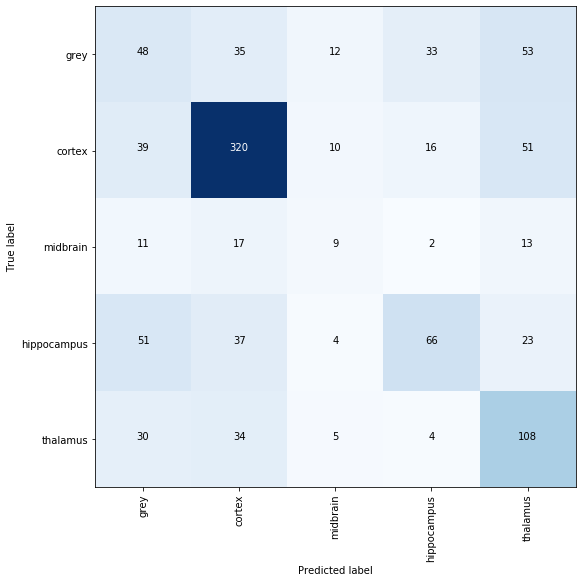

In [26]:
plot_confusion_matrix(test_cm, class_names=keepers)
plt.show()